In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import training_semi_supervised_node_classification

In [4]:
import model.normalizing_flow
import model.density
import plot.density

In [5]:
x = torch.zeros(3).cuda()

In [6]:
# Create a multimodal distribution
D = 64
n = 20
mode1 = torch.distributions.MultivariateNormal(
                torch.tensor([1.0] * D), 
                covariance_matrix=torch.diag(torch.tensor([.6] * D)), 
                validate_args=False
    )
mode2 = torch.distributions.MultivariateNormal(
                torch.tensor([-1.3] * D), 
                covariance_matrix=torch.diag(torch.tensor([.1] * D)), 
                validate_args=False
    )
mode3 = torch.distributions.MultivariateNormal(
                torch.tensor([0, 1.2] * (D // 2)), 
                covariance_matrix=torch.diag(torch.tensor([.3] * D)), 
                validate_args=False
    )
x = torch.cat([
    mode1.rsample((n,)),
    mode2.rsample((n,)),
    mode3.rsample((n,)),
], 0).float()

In [7]:
y = torch.tensor([0] * n + [1] * n + [2] * n).long()

In [8]:
def modes_log_density(x):
    probs = torch.stack([mode1.log_prob(x), mode2.log_prob(x), mode3.log_prob(x)])
    return torch.logsumexp(probs, 0)

In [9]:
soft = torch.zeros(x.size(0), 3)
soft[:n, 0] = 1.0
soft[n : 2 * n, 1] = 1.0
soft[2 * n :, 2] = 1.0

In [24]:
density = model.density.get_density_model(
    'FeatureSpaceDensityNormalizingFlowPerClass',
    flow_type = 'maf',
    num_layers = 10,
    gpu=True,
    verbose = True,
    iterations = 50,
)
density.fit(
    x,
    soft,
)

Fit normalizing flow with GPU acceleration.


100%|██████████| 50/50 [00:01<00:00, 27.48it/s]


Fit normalizing flow with GPU acceleration.


100%|██████████| 50/50 [00:01<00:00, 27.27it/s]


Fit normalizing flow with GPU acceleration.


100%|██████████| 50/50 [00:01<00:00, 27.07it/s]


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

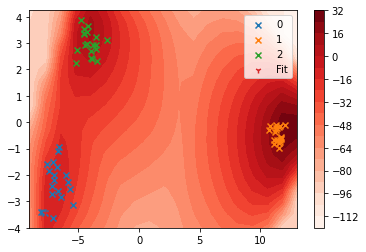

In [25]:
plot.density.plot_density(x[:1], x, density, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

In [18]:
density = model.density.get_density_model(
    'FeatureSpaceDensityNormalizingFlowPerClass',
    flow_type = 'maf',
    num_layers = 10,
    gpu=True,
    verbose = True,
    iterations = 10000,
)
density.fit(
    x,
    soft,
)

Fit normalizing flow with GPU acceleration.


100%|██████████| 10000/10000 [06:06<00:00, 27.27it/s]


Fit normalizing flow with GPU acceleration.


100%|██████████| 10000/10000 [06:07<00:00, 27.23it/s]


Fit normalizing flow with GPU acceleration.


100%|██████████| 10000/10000 [06:07<00:00, 27.22it/s]


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

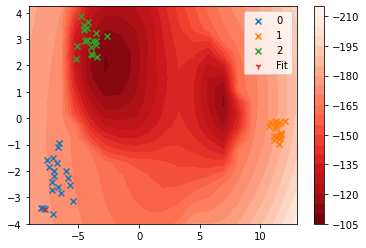

In [19]:
plot.density.plot_density(x[:1], x, density, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

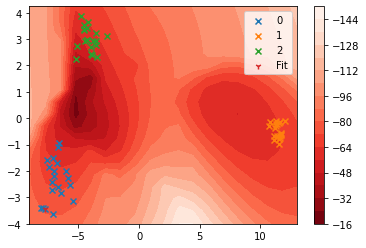

In [17]:
plot.density.plot_density(x[:1], x, density, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

In [10]:
soft2 = soft.clone()
# soft2[:n] = 0.0
density = model.density.get_density_model(
    'FeatureSpaceDensityNormalizingFlowPerClass',
    flow_type = 'maf',
    num_layers = 10,
)
density.fit(
    x,
    soft2
)

<AxesSubplot:xlabel='density', ylabel='Density'>

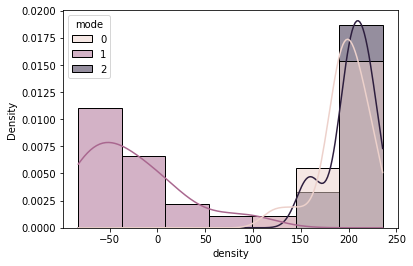

In [11]:
df = pd.DataFrame({
    'density' : density(x),
    'mode' : y,
})
sns.histplot(df, x='density', hue='mode', stat='density', common_norm=False, kde=True)

In [30]:
soft2 = soft.clone()
# soft2[:n, 0] = 0.0
density = model.density.get_density_model(
    'GaussianPerClass',
    relative=True,
)
density.fit(
    x,
    soft2
)

Covariance not positive semi-definite. Adding 1e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 9.999999999999999e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 1e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 9.999999999999999e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 1e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 9.999999999999999e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 1e-06 to the diagnoal.
Covariance not positive semi-definite. Adding 9.999999999999999e-06 to the diagnoal.


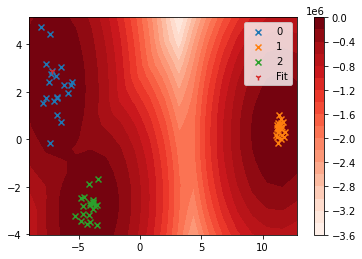

In [31]:
plot.density.plot_density(x[:1], x, density, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')
df = pd.DataFrame({
    'density' : density(x),
    'mode' : y,
})

<AxesSubplot:xlabel='density', ylabel='Density'>

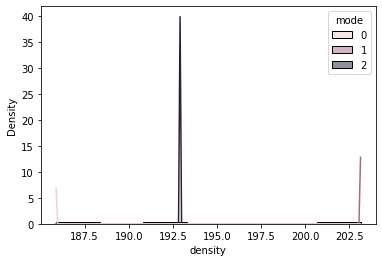

In [14]:

sns.histplot(df, x='density', hue='mode', stat='density', common_norm=False, kde=True)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

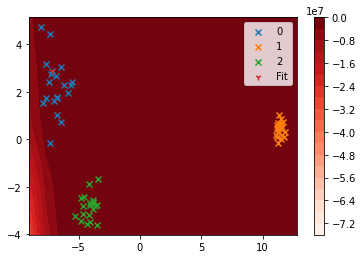

In [15]:
flow = model.normalizing_flow.NormalizingFlow('maf', 10, D, seed=1337, num_hidden=2)
flow.fit(x, weights = torch.tensor([2.0] * n + [0.0005] * n + [1.0] * n).float(), iterations=1000)
plot.density.plot_density(x[:1], x, flow, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

In [16]:
list(flow.xflow.parameters())

[Parameter containing:
 tensor([[-0.1675, -0.0011,  0.0308,  ..., -0.0999, -0.1040,  0.0090],
         [ 0.1537, -0.0696, -0.1185,  ..., -0.1009,  0.0120,  0.0776],
         [ 0.1759,  0.1479,  0.1576,  ..., -0.0786, -0.0115, -0.0951],
         ...,
         [-0.0435,  0.0669, -0.0939,  ..., -0.0401, -0.0023, -0.0313],
         [ 0.0099, -0.0706, -0.0099,  ..., -0.0029,  0.0126,  0.0551],
         [ 0.0863,  0.0489, -0.0346,  ..., -0.1152, -0.1062,  0.0167]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0277, -0.0664,  0.0125, -0.1087, -0.0527,  0.1771,  0.0175, -0.0595,
          0.1079,  0.0787, -0.0165,  0.0207, -0.0315,  0.0810,  0.0100,  0.1005,
         -0.0098,  0.1155, -0.0459, -0.0223,  0.0867, -0.0335, -0.0791,  0.0207,
          0.0477, -0.0724,  0.0119,  0.0987, -0.0522,  0.1084, -0.0066,  0.0284,
         -0.0015, -0.1093,  0.1048, -0.1084,  0.0512,  0.1668,  0.0203, -0.0087,
         -0.0230,  0.1204, -0.0486,  0.0367,  0.0878, -0.0986, -0.0804, -0.1172

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

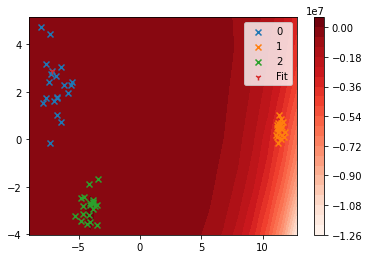

In [17]:
flow = model.normalizing_flow.NormalizingFlow('maf', 10, D, seed=1337, num_hidden=2)
flow.fit(x[2*n:], iterations=50)
plot.density.plot_density(x[:1], x, flow, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

In [18]:
flow2 = model.normalizing_flow.NormalizingFlow('maf', 10, D, seed=1337, num_hidden=2)
flow2.fit(x[10:20], iterations=100)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

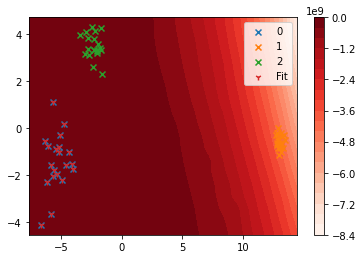

In [19]:
plot.density.plot_density(x[:20], x, flow2, y, {i : str(i) for i in range(3)}, 
                seed=1337, bins=20, levels=20, dimensionality_reduction='pca', num_samples=50000,
            sampling_stragey = 'random')

In [20]:
flow3 = model.normalizing_flow.NormalizingFlow('maf', 10, D, seed=1337, num_hidden=2)
flow3.fit(x[10:20], iterations=100)